In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# from rdkit import Chem
# from rdkit.Chem import Descriptors, AllChem, DataStructs
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_df = pd.read_csv('../Data/train.csv')
test_df = pd.read_csv('../Data/test.csv')
submission_df = pd.read_csv('../Data/sample_submission.csv')

train_df.head()

,Batch_ID,T80,Smiles,Mass,HAcceptors,HDonors,LogP,Asphericity,Rg,TPSA,...,SDOS4.5,SDOS4.6,SDOS4.7,SDOS4.8,SDOS4.9,SDOS5.0,SDOS5.1,SDOS5.2,SDOS5.3,SDOS5.4
0,Train-01,103.86,CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1,410.692,2,0,9.6070,0.301361,5.187321,0.00,...,1.717761,1.970186,1.760071,1.224983,0.664733,0.282353,0.096763,0.034589,0.030793,0.057340
1,Train-02,101.13,CCCCCCCCCCCCc1ccsc1-c1cccs1,334.594,2,0,7.9400,0.367472,4.141425,0.00,...,0.012396,0.046031,0.133124,0.299840,0.525958,0.718549,0.764711,0.634854,0.414866,0.225909
2,Train-03,78.30,CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1,398.553,4,0,4.0182,0.799589,5.368024,40.62,...,2.421162,2.703267,2.352276,1.595867,0.845839,0.354620,0.127878,0.060600,0.064782,0.098908
3,Train-04,71.88,O=C1c2ccccc2C(=O)c2cc(-c3ccc(-c4cccs4)s3)ccc21,372.470,4,0,5.9190,0.793825,4.948903,34.14,...,0.886320,0.579059,0.345148,0.246564,0.276259,0.381997,0.495304,0.566935,0.594203,0.614075
4,Train-05,68.37,CC(C)(C)OC(=O)n1ccc2ccc(-c3ccc(-c4ccc(-c5cccs5...,457.620,5,0,8.5485,0.671148,5.994751,31.23,...,0.487723,0.245764,0.249019,0.363222,0.474953,0.505358,0.440671,0.330129,0.234649,0.183111


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Columns: 146 entries, Batch_ID to SDOS5.4
dtypes: float64(138), int64(6), object(2)
memory usage: 48.0+ KB


In [6]:
object_columns = train_df.select_dtypes(include='object').columns
print(f"Nama kolom object: {list(object_columns)}")

Nama kolom object: ['Batch_ID', 'Smiles']


In [7]:
print(train_df[object_columns].head(45))

    Batch_ID                                             Smiles
0   Train-01             CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1
1   Train-02                        CCCCCCCCCCCCc1ccsc1-c1cccs1
2   Train-03  CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1
3   Train-04     O=C1c2ccccc2C(=O)c2cc(-c3ccc(-c4cccs4)s3)ccc21
4   Train-05  CC(C)(C)OC(=O)n1ccc2ccc(-c3ccc(-c4ccc(-c5cccs5...
5   Train-06  c1csc(-c2ccc(-c3ccc(-c4ccc5c(c4)C4(c6ccccc6Oc6...
6   Train-07  CC(C)(C)OC(=O)CN1C(=O)CCc2cc(-c3ccc(-c4cccs4)s...
7   Train-08      Cc1cc(-c2ccc(-c3ccc(-c4cccs4)s3)cc2)c2nnnn2c1
8   Train-09  CCCCCCCCCCCCc1ccsc1-c1ccc(-c2ccc(-c3ccc(-c4ccc...
9   Train-10  Cc1ccc(-c2ccc(-c3ccc(-c4cccs4)s3)cc2)cc1Cc1ccc...
10  Train-11  CC(NC(=O)OC(C)(C)C)c1ccc(-c2ccc(-c3ccc(-c4cccs...
11  Train-12  c1ccc([Si](c2ccccc2)(c2ccccc2)c2cccc(-c3ccc(-c...
12  Train-13  CCCCC(CC)COc1c2cc(-c3ccc4oc(-c5ccc(N(c6ccccc6)...
13  Train-14  CC(C)(C)c1ccc(-c2ccc(C(C)(C)C)cc2-c2cc3sc(-c4c...
14  Train-15  Cc1ccc(NC(=O)OC(C)(C)C)cc1

In [8]:
for col in object_columns:
    print(f"'{col}': {train_df[col].nunique()} unique values")

'Batch_ID': 42 unique values
'Smiles': 42 unique values


In [9]:
display(train_df.describe())

,T80,Mass,HAcceptors,HDonors,LogP,Asphericity,Rg,TPSA,RingCount,NumRotatableBonds,...,SDOS4.5,SDOS4.6,SDOS4.7,SDOS4.8,SDOS4.9,SDOS5.0,SDOS5.1,SDOS5.2,SDOS5.3,SDOS5.4
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,22.710476,601.389929,5.500000,0.309524,10.854289,0.532680,6.355368,36.990952,5.714286,11.690476,...,0.874759,0.763264,0.668653,0.595143,0.560035,0.571105,0.624577,0.706185,0.786314,0.833714
std,26.896407,176.251665,2.244234,0.604378,3.504098,0.217963,1.264587,30.888275,1.743080,6.884015,...,0.993377,0.872205,0.720167,0.580504,0.541022,0.568734,0.597270,0.665208,0.769713,0.814881
min,1.500000,238.315000,2.000000,0.000000,3.872100,0.169945,3.629240,0.000000,2.000000,2.000000,...,0.012396,0.014004,0.024370,0.037166,0.039435,0.051700,0.049996,0.034589,0.030793,0.057340
25%,5.085000,483.691250,4.000000,0.000000,8.369075,0.345224,5.593117,17.980000,5.000000,4.000000,...,0.158100,0.107728,0.150733,0.195820,0.239064,0.283035,0.220079,0.235281,0.250824,0.236877
50%,10.485000,570.826000,5.000000,0.000000,10.801500,0.541883,6.289388,36.225000,5.000000,14.000000,...,0.449055,0.363273,0.333565,0.330316,0.410859,0.371651,0.427824,0.475996,0.488769,0.473099
75%,30.182500,751.587000,6.750000,0.000000,13.054580,0.714117,6.951290,50.075000,7.000000,17.000000,...,1.232151,1.191322,1.086311,0.913003,0.712412,0.718112,0.964893,1.124234,1.386218,1.418428
max,103.860000,1005.426000,12.000000,2.000000,17.767000,0.913014,10.519416,132.990000,9.000000,23.000000,...,3.765836,2.986408,2.431030,2.394081,2.738119,3.060757,3.103451,2.908210,2.818927,3.188643


In [10]:
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]

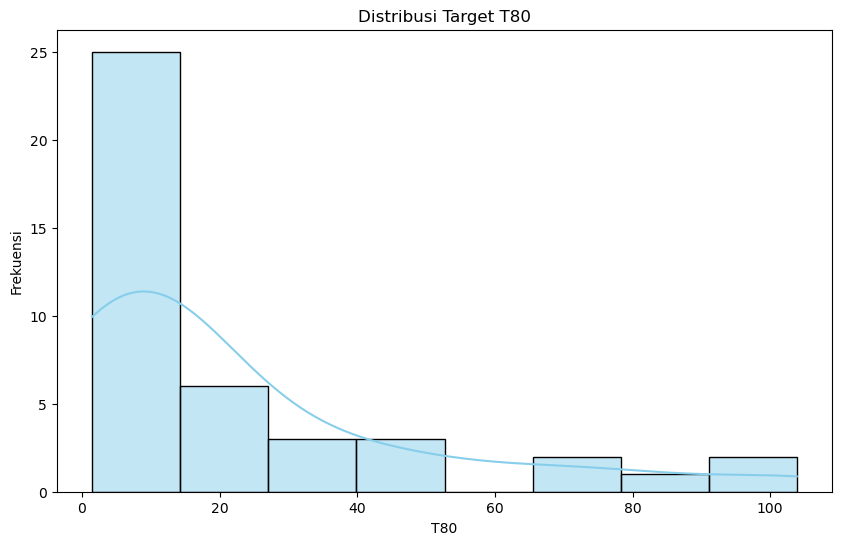

In [11]:
# Visualisasi distribusi target T80
plt.figure(figsize=(10, 6))
sns.histplot(train_df['T80'], kde=True, color='skyblue', edgecolor='black')
plt.title("Distribusi Target T80")
plt.xlabel("T80")
plt.ylabel("Frekuensi")
plt.show()

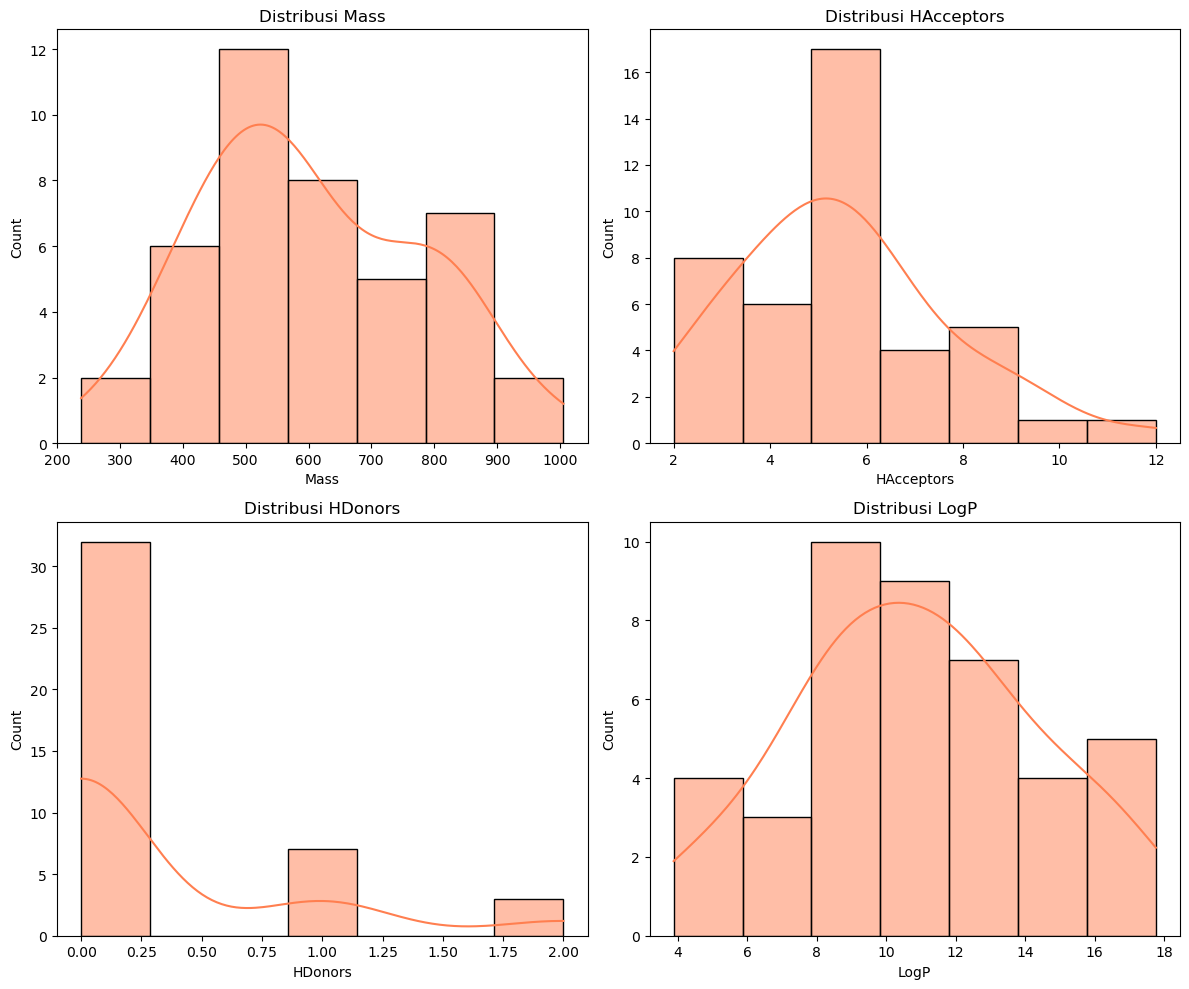

In [12]:
# Visualisasi distribusi beberapa fitur utama (misalnya: Mass, HAcceptors, HDonors, LogP)
features_to_plot = ['Mass', 'HAcceptors', 'HDonors', 'LogP']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, feature in zip(axes.flatten(), features_to_plot):
    sns.histplot(train_df[feature], kde=True, ax=ax, color='coral', edgecolor='black')
    ax.set_title(f"Distribusi {feature}")
    ax.set_xlabel(feature)
plt.tight_layout()
plt.show()

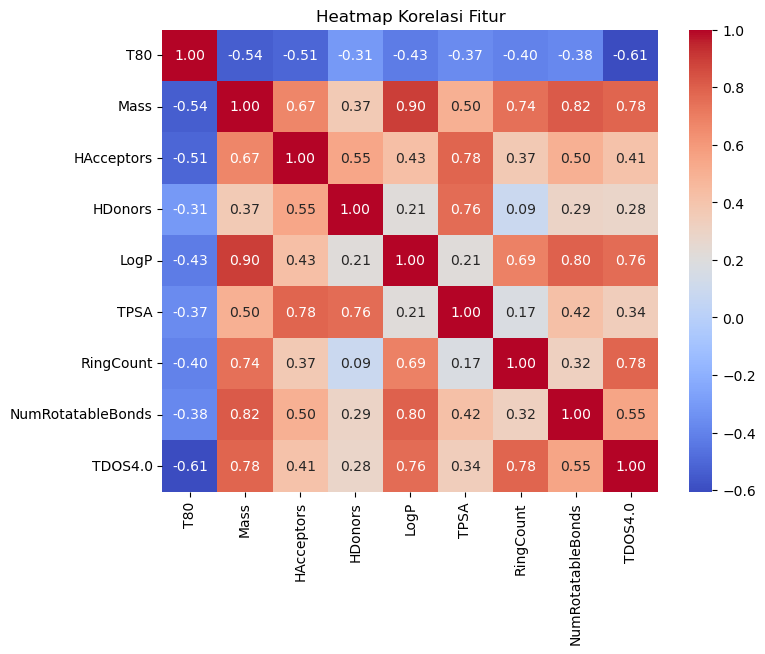

In [13]:
relevant_features = ['T80', 'Mass', 'HAcceptors', 'HDonors', 'LogP', 'TPSA', 'RingCount', 'NumRotatableBonds', 'TDOS4.0']
corr_matrix = train_df[relevant_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap Korelasi Fitur")
plt.show()

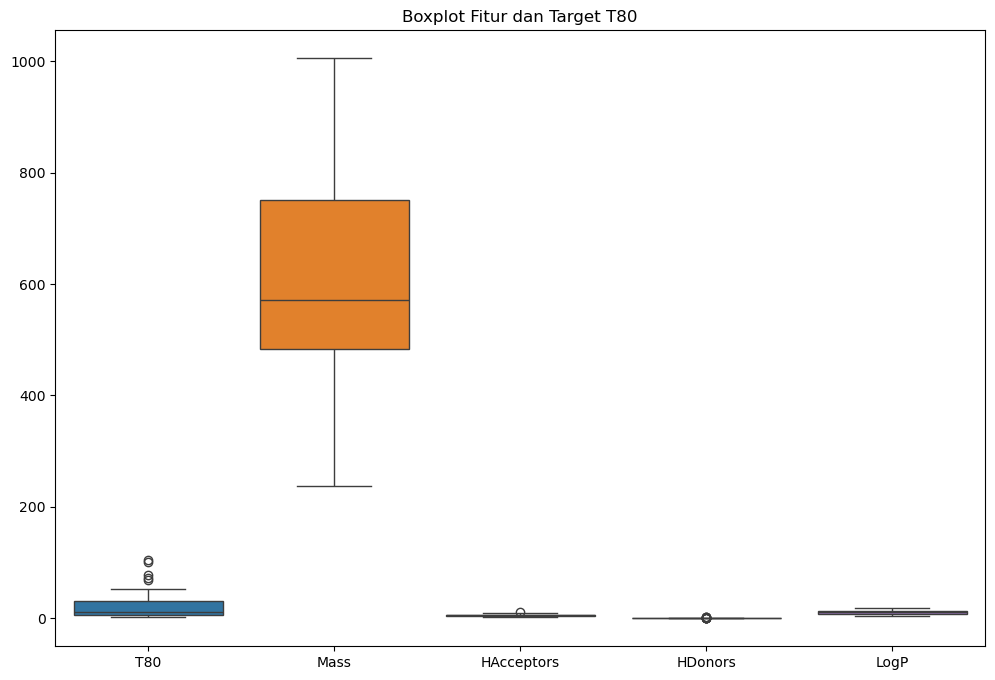

In [14]:
# 1. Boxplot untuk identifikasi outlier
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_df[['T80', 'Mass', 'HAcceptors', 'HDonors', 'LogP']])
plt.title("Boxplot Fitur dan Target T80")
plt.show()

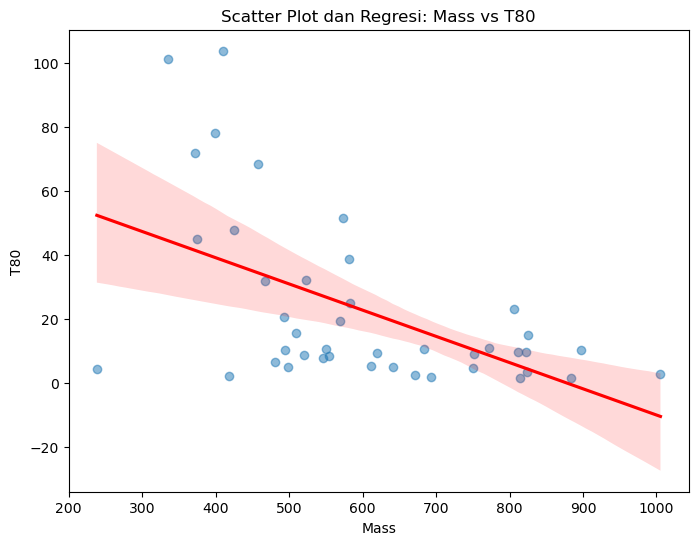

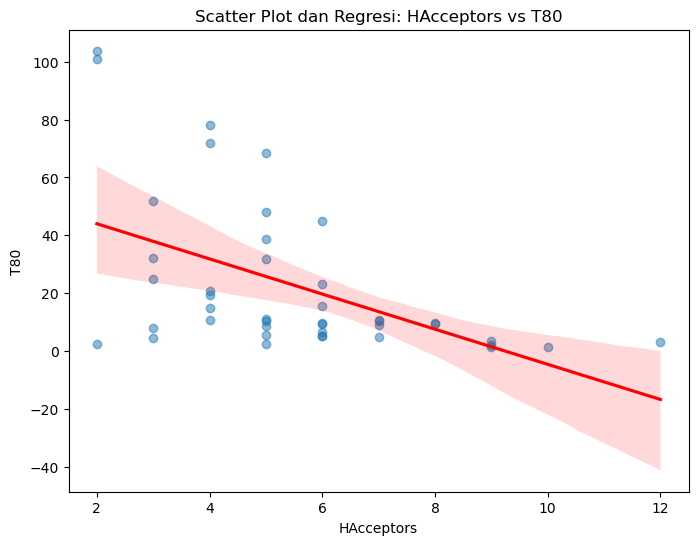

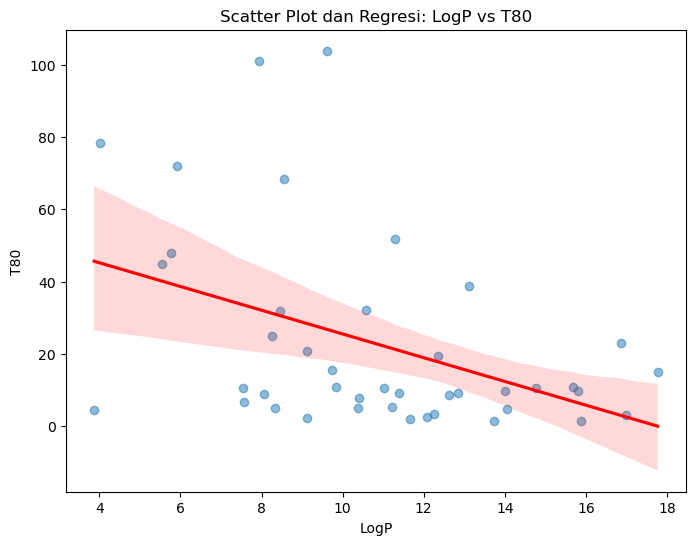

In [15]:
# 2. Scatter plot dengan garis regresi untuk fitur utama terhadap T80
features = ['Mass', 'HAcceptors',  'LogP']
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=train_df[feature], y=train_df['T80'], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.title(f"Scatter Plot dan Regresi: {feature} vs T80")
    plt.xlabel(feature)
    plt.ylabel("T80")
    plt.show()

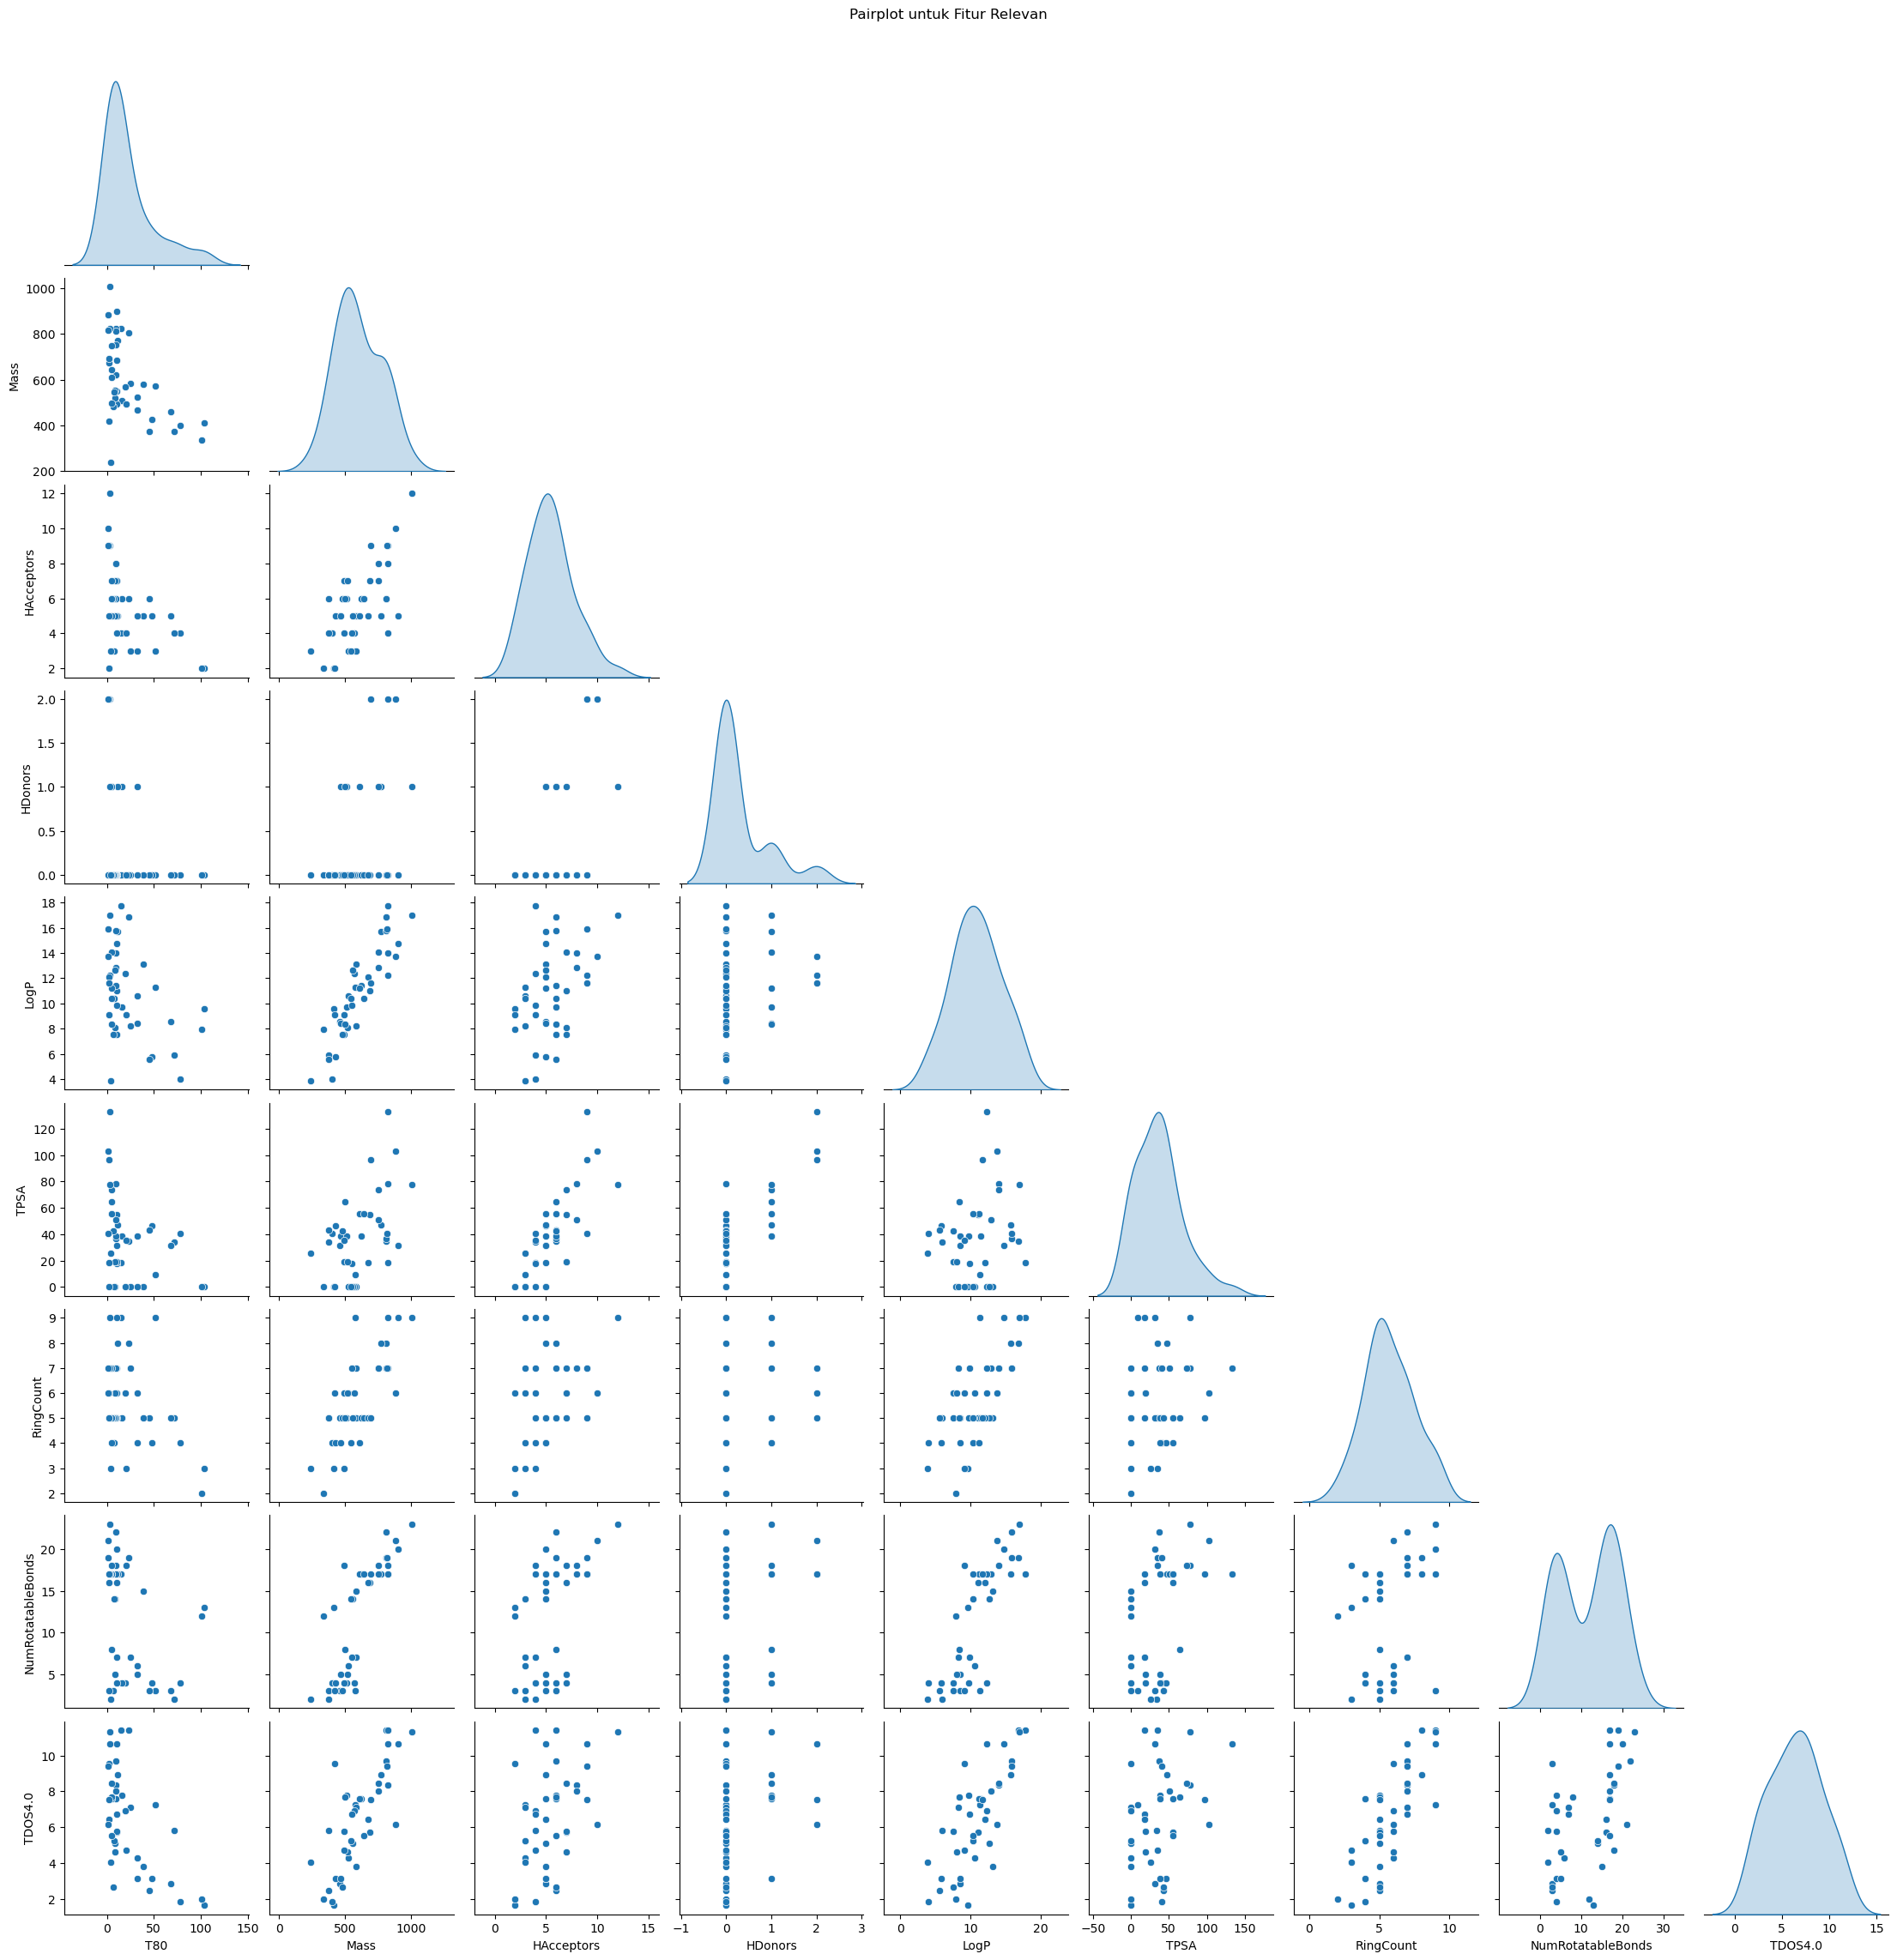

In [16]:
sns.pairplot(train_df[relevant_features], diag_kind='kde', corner=True)
plt.suptitle("Pairplot untuk Fitur Relevan", y=1.02)
plt.show()

In [17]:
from sklearn.decomposition import PCA
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'T80' in numeric_cols:
    numeric_cols.remove('T80')
features_for_pca = train_df[numeric_cols]
features_for_pca = features_for_pca.fillna(features_for_pca.mean())

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_pca)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

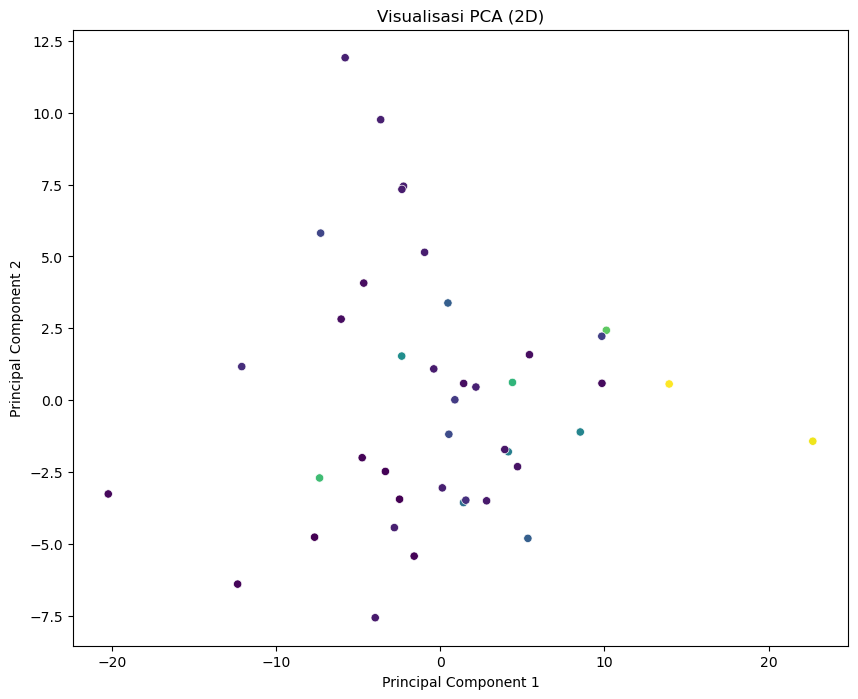

In [18]:
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['T80'] = train_df['T80'].values

# Visualisasi PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='T80', palette='viridis', data=pca_df, legend=False)
plt.title("Visualisasi PCA (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

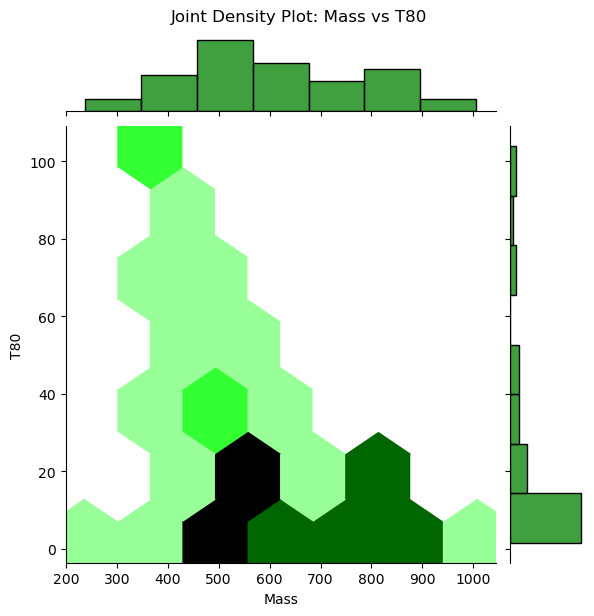

In [19]:
sns.jointplot(x=train_df['Mass'], y=train_df['T80'], kind='hex', color='green')
plt.suptitle("Joint Density Plot: Mass vs T80", y=1.02)
plt.xlabel("Mass")
plt.ylabel("T80")
plt.show()

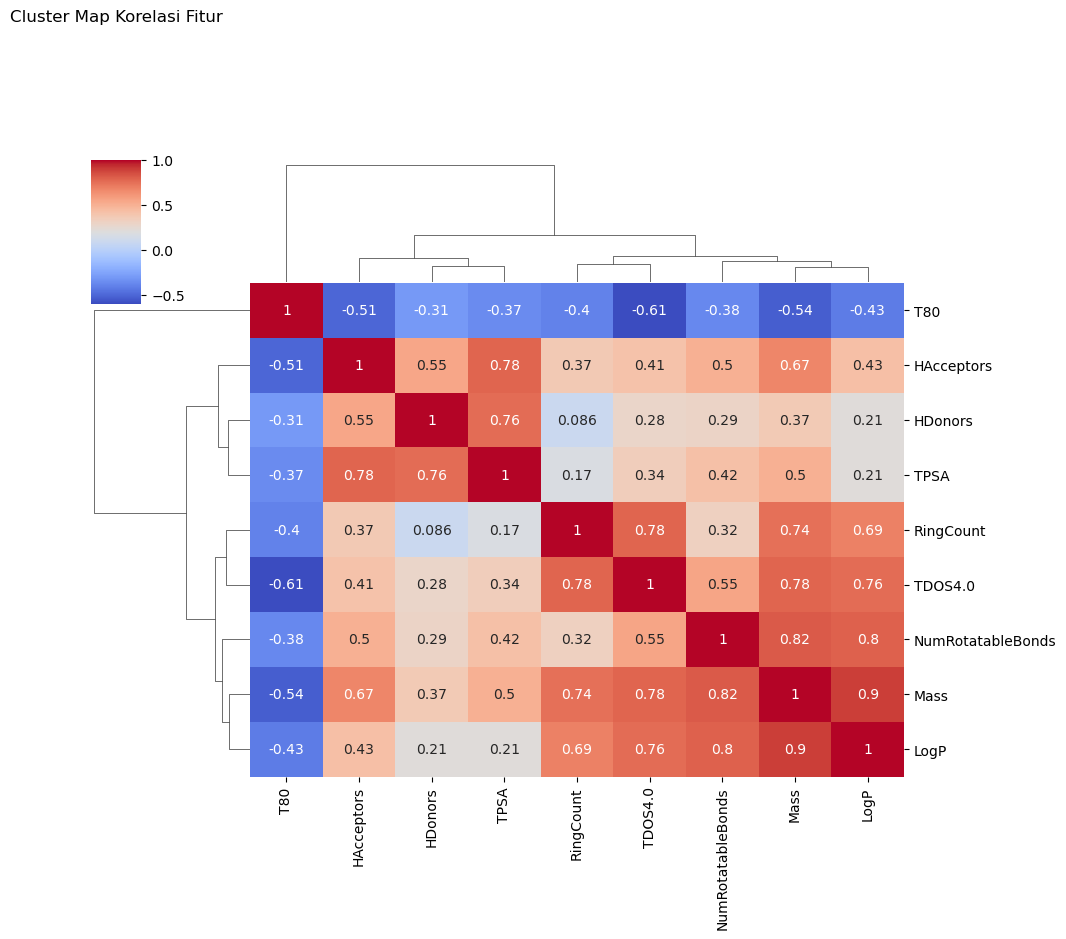

In [20]:
relevant_features = ['T80', 'Mass', 'HAcceptors', 'HDonors', 'LogP', 'TPSA', 'RingCount', 'NumRotatableBonds', 'TDOS4.0']
corr_matrix = train_df[relevant_features].corr()

sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', figsize=(10, 8))
plt.title("Cluster Map Korelasi Fitur", pad=100)
plt.show()

--- Korelasi Fitur Numerik dengan T80 (diurutkan) ---
T80                    1.000000
S16                    0.620334
S12                    0.619393
S15                    0.617380
S17                    0.615652
S13                    0.613732
S14                    0.605401
S10                    0.597580
S20                    0.597489
S18                    0.593345
S19                    0.587523
T5                     0.584818
S11                    0.584701
T9                     0.581914
T7                     0.576488
T6                     0.569464
S9                     0.554246
S8                     0.552182
T17                    0.551179
T15                    0.545524
T14                    0.537479
S7                     0.529519
PrimeExcite(eV)        0.524539
S1                     0.515560
T4                     0.515519
T18                    0.515055
T20                    0.514255
T8                     0.513982
T16                    0.513540
T2                

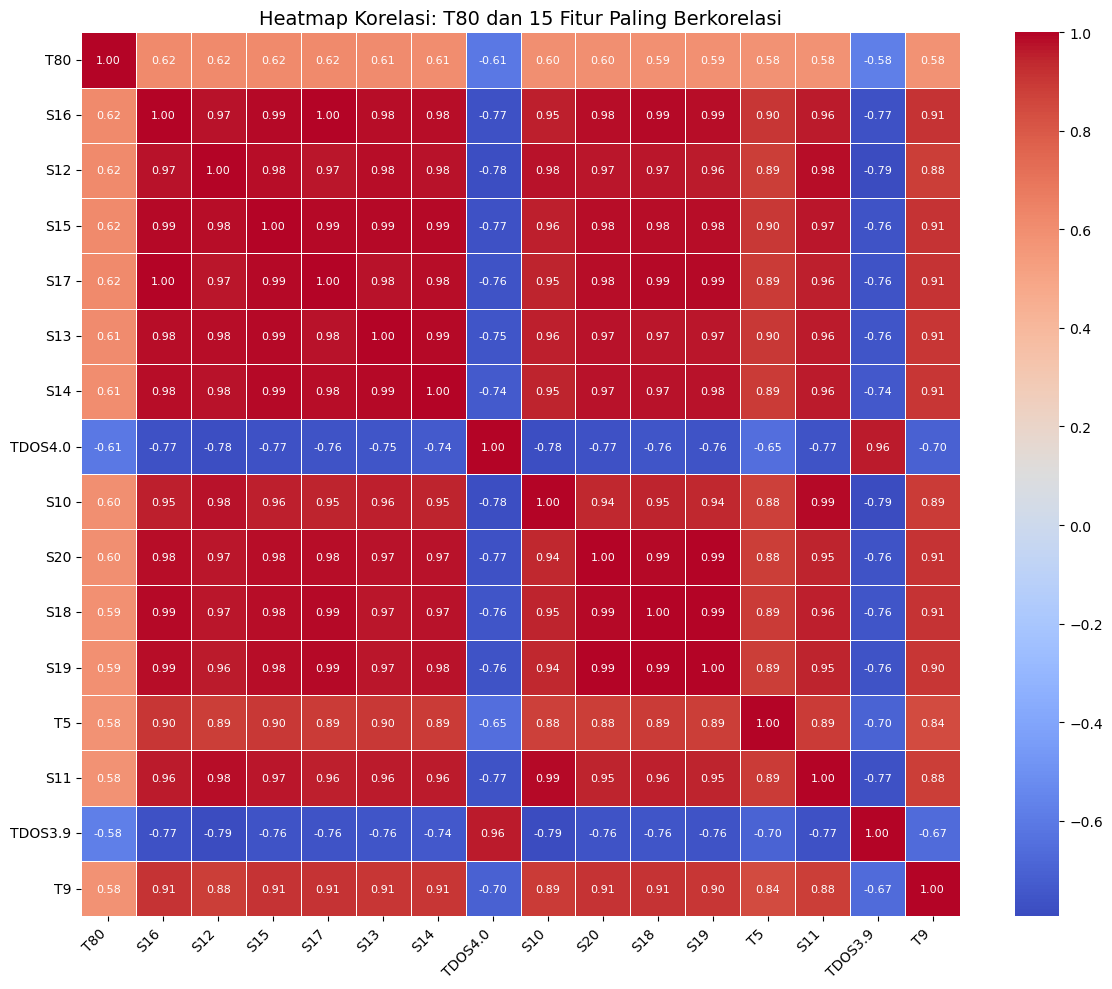

In [21]:
numerical_features = train_df.select_dtypes(include=np.number).columns.tolist()


if 'T80' not in numerical_features:
     
     print("Kolom T80 tidak ditemukan di fitur numerik.")
     
else:
     correlation_matrix = train_df[numerical_features].corr() 
     
     if 'T80' in correlation_matrix.columns:
         corr_with_target = correlation_matrix['T80'].sort_values(ascending=False)
         print("--- Korelasi Fitur Numerik dengan T80 (diurutkan) ---")
         pd.set_option('display.max_rows', 200) 
         print(corr_with_target)
         pd.reset_option('display.max_rows') 

         n_top_features = 15 
         print(f"\n--- {n_top_features} Fitur Paling Berkorelasi Positif dengan T80 ---")
         print(corr_with_target.iloc[1:n_top_features+1])
         print(f"\n--- {n_top_features} Fitur Paling Berkorelasi Negatif dengan T80 ---")
         print(corr_with_target.tail(n_top_features).sort_values(ascending=True))

         most_correlated_features_indices = correlation_matrix['T80'].abs().sort_values(ascending=False).head(n_top_features + 1).index
         valid_indices = [idx for idx in most_correlated_features_indices if idx in train_df.columns]
         limited_corr_matrix = train_df[valid_indices].corr()

         plt.figure(figsize=(12, 10))
         sns.heatmap(limited_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8}) 
         plt.title(f'Heatmap Korelasi: T80 dan {n_top_features} Fitur Paling Berkorelasi', fontsize=14)
         plt.xticks(rotation=45, ha='right') 
         plt.yticks(rotation=0)
         plt.tight_layout() 
         plt.show()
         
     else:
         print("Error: T80 tidak ditemukan di kolom matriks korelasi.")

# Feature Engineering

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

In [23]:
# --- STEP 2: Definisi Fitur Awal dan Target ---
print("\n--- Step 2: Mendefinisikan Fitur Awal dan Target ---")
TARGET = 'T80'
cols_to_drop = ['id', 'Smiles', TARGET]

# Identifikasi fitur awal (semua kolom kecuali yang di-drop)
# Pastikan kolom yang di-drop benar-benar ada
cols_to_drop_train = [col for col in cols_to_drop if col in train_df.columns]
initial_features = [col for col in train_df.columns if col not in cols_to_drop_train]

# Pilih HANYA fitur numerik untuk FE sederhana ini
X_numeric = train_df[initial_features].select_dtypes(include=np.number).copy()
y = train_df[TARGET]

# Lakukan hal yang sama untuk test set, pastikan fiturnya sama
cols_to_drop_test = [col for col in cols_to_drop if col in test_df.columns]
X_test_numeric = test_df.drop(columns=cols_to_drop_test, errors='ignore') # Drop ID/SMILES
X_test_numeric = X_test_numeric.select_dtypes(include=np.number).copy()

# Pastikan kolom di test set cocok dengan train set (setelah seleksi numerik)
missing_in_test = [col for col in X_numeric.columns if col not in X_test_numeric.columns]
extra_in_test = [col for col in X_test_numeric.columns if col not in X_numeric.columns]

if missing_in_test or extra_in_test:
    print(f"PERINGATAN: Ketidakcocokan kolom numerik awal!")
    print(f"  Missing di Test: {missing_in_test}")
    print(f"  Extra di Test: {extra_in_test}")
    # Opsi paling aman: gunakan irisan kolom
    common_numeric_features = list(set(X_numeric.columns) & set(X_test_numeric.columns))
    print(f"Menggunakan {len(common_numeric_features)} fitur numerik yang sama.")
    X = X_numeric[common_numeric_features]
    X_test = X_test_numeric[common_numeric_features]
else:
    print(f"Menggunakan {X_numeric.shape[1]} fitur numerik awal.")
    X = X_numeric
    X_test = X_test_numeric



--- Step 2: Mendefinisikan Fitur Awal dan Target ---
Menggunakan 143 fitur numerik awal.


In [24]:
# --- STEP 3: Transformasi Target (Log) ---
print("\n--- Step 3: Transformasi Target (Log1p) ---")
y_log = np.log1p(y)
print("Target T80 telah di-transformasi menggunakan log1p.")
# Visualisasi jika perlu (kode dari sebelumnya)
# plt.figure(figsize=(6, 4)); sns.histplot(y_log, kde=True); plt.title('Distribusi log1p(T80)'); plt.show()


--- Step 3: Transformasi Target (Log1p) ---
Target T80 telah di-transformasi menggunakan log1p.


In [25]:
# --- STEP 4: Imputasi Missing Values (jika ada) ---
print("\n--- Step 4: Imputasi Missing Values (Median) ---")
print(f"Missing di X sebelum imputasi: {X.isnull().sum().sum()}")
print(f"Missing di X_test sebelum imputasi: {X_test.isnull().sum().sum()}")

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

print(f"Missing di X setelah imputasi: {X_imputed.isnull().sum().sum()}")
print(f"Missing di X_test setelah imputasi: {X_test_imputed.isnull().sum().sum()}")


--- Step 4: Imputasi Missing Values (Median) ---
Missing di X sebelum imputasi: 0
Missing di X_test sebelum imputasi: 0
Missing di X setelah imputasi: 0
Missing di X_test setelah imputasi: 0


In [26]:
# --- STEP 5: Feature Engineering Sederhana - Polinomial ---
print("\n--- Step 5: Membuat Fitur Polinomial (Derajat 2) ---")
# Ini akan membuat fitur X1, X2, X1^2, X1*X2, X2^2, dst.
# include_bias=False agar tidak menambah kolom konstanta 1
# interaction_only=False agar menyertakan fitur kuadrat (X1^2, X2^2)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

# Fit HANYA pada data training
poly.fit(X_imputed)

# Transform train dan test
# Hati-hati: Ini akan sangat meningkatkan jumlah fitur!
X_poly = pd.DataFrame(poly.transform(X_imputed), index=X.index, columns=poly.get_feature_names_out(X.columns))
X_test_poly = pd.DataFrame(poly.transform(X_test_imputed), index=X_test.index, columns=poly.get_feature_names_out(X_test.columns))

print(f"Jumlah fitur SEBELUM polinomial: {X_imputed.shape[1]}")
print(f"Jumlah fitur SETELAH polinomial (derajat 2): {X_poly.shape[1]}")
print("Contoh nama fitur polinomial:", list(X_poly.columns[:5]), "...", list(X_poly.columns[-5:]))


--- Step 5: Membuat Fitur Polinomial (Derajat 2) ---
Jumlah fitur SEBELUM polinomial: 143
Jumlah fitur SETELAH polinomial (derajat 2): 10439
Contoh nama fitur polinomial: ['Mass', 'HAcceptors', 'HDonors', 'LogP', 'Asphericity'] ... ['SDOS5.2 SDOS5.3', 'SDOS5.2 SDOS5.4', 'SDOS5.3^2', 'SDOS5.3 SDOS5.4', 'SDOS5.4^2']


In [27]:
# --- STEP 6: Feature Scaling (Setelah FE) ---
print("\n--- Step 6: Feature Scaling (StandardScaler) ---")
# Scaling dilakukan SETELAH membuat fitur polinomial

scaler = StandardScaler()

# Fit scaler HANYA pada data training (X_poly)
scaler.fit(X_poly)

# Transform X_poly dan X_test_poly
X_scaled = pd.DataFrame(scaler.transform(X_poly), columns=X_poly.columns, index=X_poly.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_poly), columns=X_test_poly.columns, index=X_test_poly.index)

print("Scaling selesai. Contoh data setelah scaling (fitur polinomial):")
print(X_scaled.head())


--- Step 6: Feature Scaling (StandardScaler) ---
Scaling selesai. Contoh data setelah scaling (fitur polinomial):
       Mass  HAcceptors   HDonors      LogP  Asphericity        Rg      TPSA  \
0 -1.095079   -1.578457 -0.518344 -0.360266    -1.074144 -0.934855 -1.212089   
1 -1.532070   -1.578457 -0.518344 -0.841762    -0.767150 -1.771946 -1.212089   
2 -1.164787   -0.676481 -0.518344 -1.974532     1.239411 -0.790228  0.118914   
3 -1.314568   -0.676481 -0.518344 -1.425506     1.212642 -1.125675 -0.093418   
4 -0.825596   -0.225494 -0.518344 -0.666003     0.642986 -0.288623 -0.188770   

   RingCount  NumRotatableBonds  NumHeteroatoms  ...  SDOS5.1^2  \
0  -1.576054           0.192533       -1.624537  ...  -0.466946   
1  -2.156705           0.045508       -1.624537  ...  -0.098358   
2  -0.995402          -1.130692       -0.056019  ...  -0.462468   
3  -0.414751          -1.424741       -0.840278  ...  -0.315799   
4  -0.414751          -1.277716       -0.448148  ...  -0.348554   

 

In [28]:
# --- STEP 7: Persiapan Akhir untuk Pemodelan ---
print("\n--- Step 7: Data Siap untuk Feature Selection & Pemodelan ---")
print(f"Shape data training siap (X_train_ready): {X_scaled.shape}")
print(f"Shape data target training siap (y_train_ready): {y_log.shape}")
print(f"Shape data test siap (X_test_ready): {X_test_scaled.shape}")

print("\nPERINGATAN PENTING:")
print("Jumlah fitur sekarang sangat besar karena fitur polinomial.")
print("Langkah selanjutnya WAJIB melibatkan FEATURE SELECTION yang agresif")
print("(misalnya SelectKBest, LassoCV, RFECV) untuk mengurangi dimensi")
print("sebelum melatih model akhir untuk menghindari overfitting parah.")

# Contoh Placeholder untuk Langkah Berikutnya (Feature Selection)
from sklearn.feature_selection import SelectKBest, f_regression
K_FEATURES = 50 # PILIH JUMLAH FITUR YANG JAUH LEBIH KECIL (misal 30-60)
print(f"\nContoh Langkah Berikutnya: Memilih {K_FEATURES} fitur terbaik...")
selector = SelectKBest(score_func=f_regression, k=K_FEATURES)
selector.fit(X_scaled, y_log) # Gunakan X_scaled dan y_log

X_train_final = X_scaled.loc[:, selector.get_support()]
X_test_final = X_test_scaled.loc[:, selector.get_support()]

print(f"Shape data setelah SelectKBest(k={K_FEATURES}):")
print(f"  X_train_final: {X_train_final.shape}")
print(f"  X_test_final: {X_test_final.shape}")
print("Data ini (X_train_final, y_log, X_test_final) siap untuk pemodelan (Ridge, SVR, dll).")


--- Step 7: Data Siap untuk Feature Selection & Pemodelan ---
Shape data training siap (X_train_ready): (42, 10439)
Shape data target training siap (y_train_ready): (42,)
Shape data test siap (X_test_ready): (9, 10439)

PERINGATAN PENTING:
Jumlah fitur sekarang sangat besar karena fitur polinomial.
Langkah selanjutnya WAJIB melibatkan FEATURE SELECTION yang agresif
(misalnya SelectKBest, LassoCV, RFECV) untuk mengurangi dimensi
sebelum melatih model akhir untuk menghindari overfitting parah.

Contoh Langkah Berikutnya: Memilih 50 fitur terbaik...
Shape data setelah SelectKBest(k=50):
  X_train_final: (42, 50)
  X_test_final: (9, 50)
Data ini (X_train_final, y_log, X_test_final) siap untuk pemodelan (Ridge, SVR, dll).


# Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
K_FEATURES = 50 
print(f"\nContoh Langkah Berikutnya: Memilih {K_FEATURES} fitur terbaik...")
selector = SelectKBest(score_func=f_regression, k=K_FEATURES)
selector.fit(X_scaled, y_log) 

X_train_final = X_scaled.loc[:, selector.get_support()] 
X_test_final = X_test_scaled.loc[:, selector.get_support()] 


Contoh Langkah Berikutnya: Memilih 50 fitur terbaik...


In [31]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler # Meskipun data mungkin sudah di-scale, pipeline aman
from sklearn.pipeline import Pipeline

# Model Regresi
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [32]:
if 'X_train_final' not in locals() or 'y_log' not in locals():
    print("ERROR: Variabel 'X_train_final' atau 'y_log' tidak ditemukan.")
    print("Pastikan Anda telah menjalankan langkah feature selection sebelumnya.")
    # Hentikan eksekusi jika data tidak ada
    raise NameError("Data training final tidak ditemukan untuk pemodelan.")
else:
    print(f"Data siap untuk perbandingan model:")
    print(f"  Shape X_train_final: {X_train_final.shape}")
    print(f"  Shape y_log: {y_log.shape}")

Data siap untuk perbandingan model:
  Shape X_train_final: (42, 50)
  Shape y_log: (42,)
